In [1]:
# In this notebook, you learn:
#
# 1) How to perform tanh using simpler operations like addition, multiplication, exponentiation, and division?
# 2) What is the difference when you use tanh as a single operation and when you use tanh as a combination of simpler operations?

In [2]:
import math

from graphviz import Digraph
from math import exp
from queue import Queue
from typing import Any, List, Set, Tuple, Union

In [3]:
def topological_sort(root: Any) -> List[Any]:
    visited: Set[Any] = set()
    topo_order: List[Any] = []
    def dfs(node: Any):
        if node in visited:
            return
        visited.add(node)
        if node.children:
            for child in node.children:
                dfs(child)
        topo_order.append(node)
    dfs(root)
    topo_order.reverse()
    return topo_order

In [123]:
class Value:
    def __init__(self, data: float, label: str="", operation: str=None, children: Tuple=None):
        self.data = data
        self.label = label
        self.operation = operation
        self.children = children
        self.grad = 0.0
        self.grad_propagator = None
    
    def __add__(self, other: Union['Value', float, int]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data + other.data, operation="+", children=(self, other))
        def grad_propagator():
            self.grad += result.grad
            other.grad += result.grad
        result.grad_propagator = grad_propagator
        return result
    
    def __radd__(self, other: Union[float, int]) -> 'Value':
        other: Value = Value(other)
        result = Value(self.data + other.data, operation="+", children=(self, other))
        def grad_propagator():
            self.grad += result.grad
            other.grad += result.grad
        result.grad_propagator = grad_propagator
        return result
    
    def __mul__(self, other: Union['Value', float, int]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data * other.data, operation="*", children=(self, other)) 
        def grad_propagator():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result.grad_propagator = grad_propagator
        return result
    
    def __rmul__(self, other: Union[float, int]) -> 'Value':
        other = Value(other)
        result = Value(self.data * other.data, operation="*", children=(self, other)) 
        def grad_propagator():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result.grad_propagator = grad_propagator
        return result

    def __sub__(self, other: Union['Value', float, int]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data - other.data, operation=f"{self.data}-{other.data}", children=(self, other))
        def grad_propagator():
            self.grad += result.grad
            other.grad -= result.grad
        result.grad_propagator = grad_propagator
        return result

    def __rsub__(self, other: Union[float, int]) -> 'Value':
        other = Value(other)
        result = Value(other.data - self.data, operation=f"{other.data}-{self.data}", children=(other, self))
        def grad_propagator():
            self.grad -= result.grad
            other.grad += result.grad
        result.grad_propagator = grad_propagator
        return result

    def __truediv__(self, other: Union['Value', float, int]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data / other.data, operation=f"{self.data}/{other.data}", children=(self, other))
        def grad_propagator():
            self.grad += result.grad / other.data
            other.grad -= ((result.grad * self.data) / other.data**2)
        result.grad_propagator = grad_propagator
        return result

    def __pow__(self, other: Union['Value', float]) -> 'Value':
        if isinstance(other, float) or isinstance(other, int):
            other = Value(other)
        result = Value(self.data ** other.data, operation=f"{self.data}^{other.data}", children=(self, other))
        def grad_propagator():
            self.grad += result.grad * other.data * self.data**(other.data - 1)
            other.grad += result.grad * result.data * math.log(self.data)
        result.grad_propagator = grad_propagator
        return result

    def __rpow__(self, other: Union[int, float]) -> 'Value':
        other = Value(other)
        result = Value(other.data ** self.data, operation=f"{other.data}^{self.data}", children=(other, self))
        def grad_propagator():
            self.grad += result.grad * result.data * math.log(other.data)
            other.grad += result.grad * self.data * other.data**(self.data - 1)
        result.grad_propagator = grad_propagator
        return result

    # Lets implement the tanh function using other operations like addition, multiplication, exponentiation, and division.
    # This is to show that we can either implement complex operations (and their gradients) as a single automic operation 
    # or as a combination of simpler operations.
    def tanh(self) -> 'Value':
        computed_data = (math.exp(self.data) - math.exp(-self.data))/(math.exp(self.data) + math.exp(-self.data))
        result = Value(data=computed_data, operation="tanh", children=(self,))
        def grad_propagator():
            # The derivative of tanh is (1 - tanh^2). This is used to calculate the gradients of the children nodes.
            self.grad += (1.0 - computed_data**2) * result.grad
        result.grad_propagator = grad_propagator
        return result

    def backward(self):
        topo_order: List[Value] = topological_sort(self)
        self.grad = 1.0
        for node in topo_order:
            if node.grad_propagator is None:
                continue
            node.grad_propagator()

    def __repr__(self) -> str:
        return f"label: {self.label} | data: {self.data} | operation: {self.operation} | grad: {self.grad}"

In [124]:
def get_nodes_and_edges(root: Value) -> Tuple[Set[Value], Set[Tuple[Value, Value]]]:
    """Returns all the nodes and edges in the expression tree. Does not nodes for the operations.

    Args:
        root (Value): The root node (the final output object) of the expression tree.

    Returns:
        Tuple[Set[Value], Set[Tuple[Value, Value]]]: A tuple containing the set of nodes and set 
                                                     of edges in the expression tree.
    """
    nodes = set()
    edges = set()
    visited = set()
    queue = Queue()
    queue.put(root)
    while not queue.empty():
        node = queue.get()
        if node in visited:
            continue
        visited.add(node)
        nodes.add(node)
        if node.children:
            for child in node.children:
                edges.add((child, node))
                queue.put(child)
    return nodes, edges

def get_expression_graph(root: Value) -> Digraph:
    """Returns a graph that visualizes the expression created using the Value_4 objects.

    Args:
        root (Value): The root node (the final output object) of the expression tree.

    Returns:
        Digraph: DOT language graph that visualizes the expression created using the Value objects.
    """
    dot = Digraph(name="ExpressionGraph", 
                  comment="Constructs the expression graph using the Value objects.",
                  format="png",
                  graph_attr={"rankdir": "LR"})
    nodes, edges = get_nodes_and_edges(root)
    for node in nodes:
        unique_id: str = str(id(node))
        dot.node(name=unique_id, label=f"{node.label} | data {node.data:.4f} | grad {node.grad:.4f}", shape="record")
        if node.operation:
            dot.node(name=f"{unique_id}_{node.operation}", label=node.operation)
            dot.edge(tail_name=f"{unique_id}_{node.operation}", head_name=unique_id)
    for edge in edges:
        from_node, to_node = edge
        dot.edge(tail_name=str(id(from_node)), head_name=f"{str(id(to_node))}_{to_node.operation}")
    return dot

### Exponentation

In [125]:
# Lets verify each of the new operations with simple examples.
# Power operation:
var1 = Value(2.0)
var1.label = "var1"
output1 = var1**3.0
output1.label = "output1"
output1.backward()
dot1 = get_expression_graph(output1)

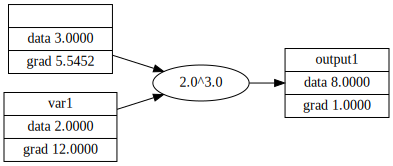

In [126]:
dot1

In [127]:
var2 = Value(2.0)
var2.label = "var2"
var3 = Value(3.0)
var3.label = "var3"
output2 = var2**var3
output2.label = "output2"
output2.backward()
dot2 = get_expression_graph(output2)

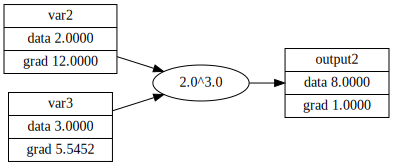

In [128]:
dot2

$$\frac{dx^n}{dx} = nx^{n-1}$$
$$\frac{da^x}{dx} = a^x\ln a$$

In [129]:
# Manually verify the gradients.
# The gradient of output wrt var2 is dvar2 = n * var2^(n-1) = 3 * 2^(3-1) = 3 * 4 = 12
dvar2 = var3.data * var2.data**(var3.data - 1)
print(f"Gradient of output2 wrt var2: {dvar2:.4f}")
print("-" * 150)
# The gradient of output wrt var3 is dvar3 = var2^n * log(var2) = 2^3 * log(2) = 8 * 0.6931 = 5.544
dvar3 = var2.data**var3.data * math.log(var2.data)
print(f"Gradient of output2 wrt var3: {dvar3:.4f}")

Gradient of output2 wrt var2: 12.0000
------------------------------------------------------------------------------------------------------------------------------------------------------
Gradient of output2 wrt var3: 5.5452


In [130]:
var4_2 = Value(3.0)
var4_2.label = "var4_2"
output3_2 = 2 ** var4_2
output3_2.label = "output3_2"
output3_2.backward()
dot3 = get_expression_graph(output3_2)

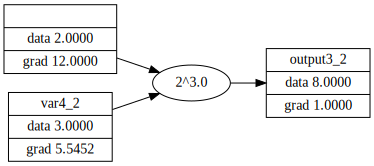

In [131]:
dot3

### Division

In [132]:
var4 = Value(18)
var4.label = "var4"
output3 = var4 / 4
output3.label = "output3"
output3.backward()
dot3 = get_expression_graph(output3)

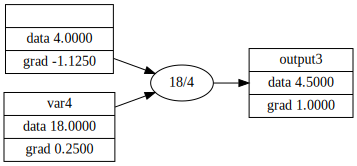

In [133]:
dot3

In [134]:
var5 = Value(18)
var5.label = "var5"
var6 = Value(4)
var6.label = "var6"
output4 = var5 / var6
output4.label = "output4"
output4.backward()
dot4 = get_expression_graph(output4)

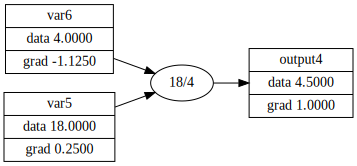

In [135]:
dot4

$$\frac{d}{dx}\left(\frac{x}{a}\right) = \frac{1}{a}$$
$$\frac{d}{dx}\left(\frac{a}{x}\right) = \frac{-a}{x^2}$$

In [136]:
# Manually verify the gradients.
# The gradient of output3 wrt var5 is dvar5 = 1/var6 = 1/4 = 0.25
dvar5 = 1 / var6.data
print(f"Gradient of output3 wrt var5: {dvar5:.4f}")
print("-" * 150)
# The gradient of output3 wrt var6 is dvar6 = -var5/var6^2 = -18/4^2 = -18/16 = -1.125
dvar6 = -var5.data / var6.data**2
print(f"Gradient of output3 wrt var6: {dvar6:.4f}") 

Gradient of output3 wrt var5: 0.2500
------------------------------------------------------------------------------------------------------------------------------------------------------
Gradient of output3 wrt var6: -1.1250


### Subtraction

In [137]:
var7 = Value(2.0)
var7.label = "var7"
output5 = var7 - 7
output5.label = "output5"
output5.backward()
dot5 = get_expression_graph(output5)

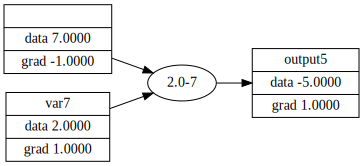

In [138]:
dot5

In [139]:
var8 = Value(2.0)
var8.label = "var8"
var9 = Value(7.0)
var9.label = "var9"
output6 = var8 - var9
output6.label = "output6"
output6.backward()
dot6 = get_expression_graph(output6)

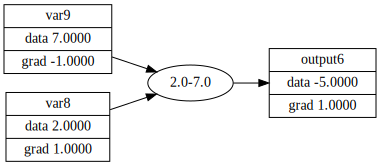

In [140]:
dot6

### Evaluating Mathematical Expression

In [147]:
var10 = Value(1.0)
var10.label = "var10"
var11 = Value(3.0)
var11.label = "var11"
var12 = Value(4.0)
var12.label = "var12"

In [148]:
# This is the same expression as computed at the end in 'step_5_automating_gradient_calculation.ipynb'. You
# can compare the gradients computed in both the notebooks to verify the correctness of the gradients.
output7 = ((var10 + var11) * var10).tanh() + var12
output7.label = "output7"
output7.backward()
dot7 = get_expression_graph(output7)

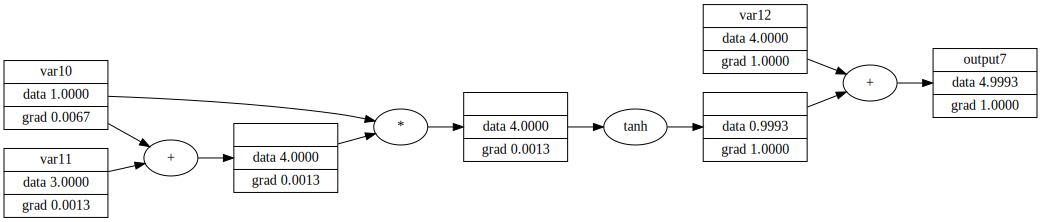

In [149]:
dot7

Now let's evaluate the same expression where tanh is broken down into smaller automic operations.

$$\tanh x = \frac{e^{2x} - 1}{e^{2x} + 1}$$

In [150]:
interim1 = (var10 + var11) * var10
interim1.label = "interim1"
interim2 = math.e ** (2 * interim1)
interim2.label = "interim2"
interim3 = (interim2 - 1) / (interim2 + 1)
interim3.label = "interim3"
output8 = interim3 + var12
output8.label = "output8"
output8.backward()
dot8 = get_expression_graph(output8)

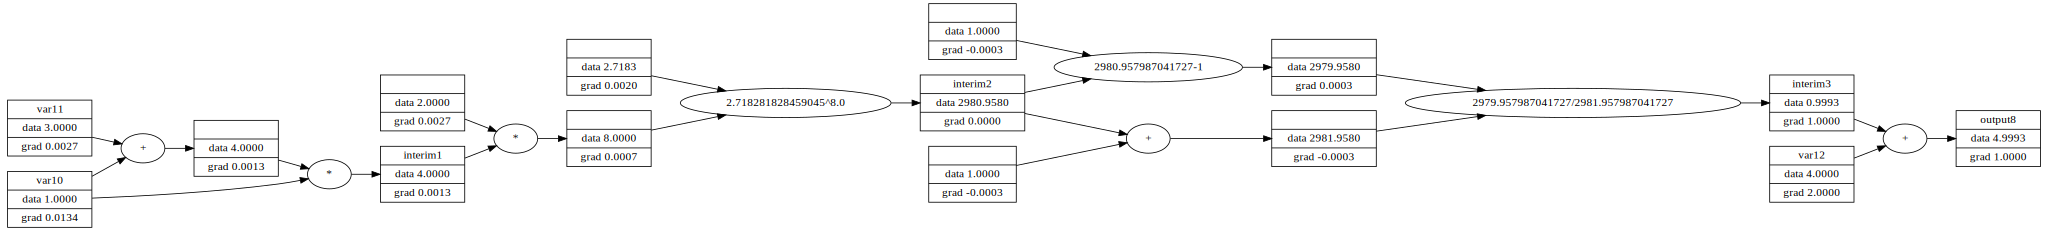

In [151]:
# You might have noticed that the derivatives are don't match with the computation above using tanh.
# This confused me for a while even though I saw Karpathy explain the same mistake in his video. So, 
# I am leaving the incorrect gradients here with explanation.
# The gradients are incorrect only for var10, var11, and var12 because these variables have been 
# used in the above expression as well. So, the 'grad' value is non-zero for these variables when
# we used them again in the current expression. The 'grad' values should be zero before 'backward'.
dot8

In [152]:
# Now, lets compute the gradients by creating new varibles with the same values.
var13 = Value(1.0)
var13.label = "var13"
var14 = Value(3.0)
var14.label = "var14"
var15 = Value(4.0)
var15.label = "var15"

In [153]:
interim4 = (var13 + var14) * var13
interim4.label = "interim4"
interim5 = math.e ** (2 * interim4)
interim5.label = "interim5"
interim6 = (interim5 - 1) / (interim5 + 1)
interim6.label = "interim6"
output8 = interim6 + var15
output8.label = "output8"
output8.backward()
dot9 = get_expression_graph(output8)

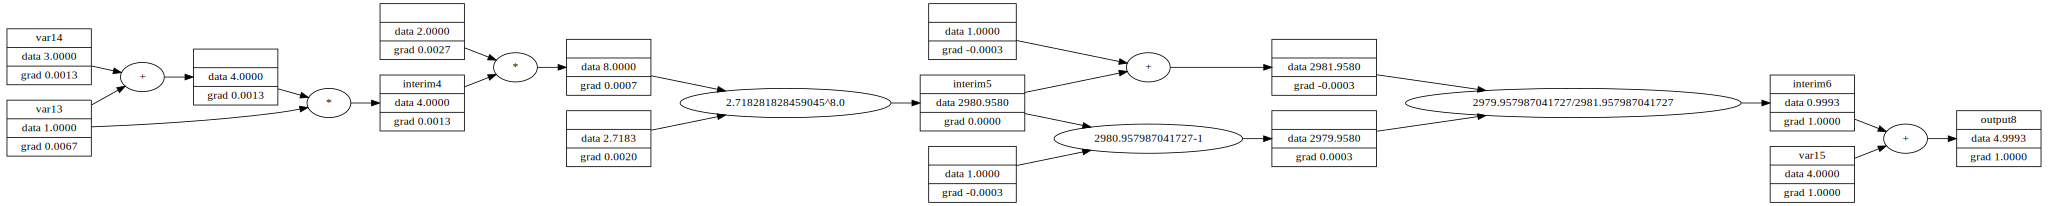

In [154]:
# Now, the gradients perfectly match with the computation above using tanh. However, notice the length
# of the graph is longer than the previous one. This is because we have broken down the tanh operation
# into multiple simpler operations.
dot9

In [155]:
# In summary, we can implement complex operations like tanh using simpler operations like addition, multiplication,
# exponentiation, and division or we can implement them as a single atomic operation. The 'grad_propagator' function
# should be implemented appropriately depending on the approach we take.
#
# 